In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
# Define transformations for the training, validation, and test sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# Load the data
data_dir = '/content/drive/MyDrive/ss programs/Soil'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform=val_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)


In [ ]:
# Define the data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pre-trained VGG16 model
# model = models.vgg19(pretrained=True)
#model = models.resnet18(pretrained=True)

model = models.vgg16(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:12<00:00, 43.4MB/s]


In [ ]:
# Freeze pre-trained layers

## for Vgg19--------------
# for param in model.parameters():
#     param.requires_grad = False

# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, len(train_data.classes))
# model = model.to(device)
# ##---------------------------

# Freeze pre-trained layers

### resnet --------
# for param in model.parameters():
#     param.requires_grad = False

# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(train_data.classes))
# model = model.to(device)
### ---------------

# Freeze pre-trained layers

###-----vgg16-------
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(train_data.classes))
model = model.to(device)

##----------------
# Freeze pre-trained layers

### mobilenetv2---
# for param in model.parameters():
#     param.requires_grad = False

# # Modify classifier head
# num_ftrs = model.classifier[1].in_features
# model.classifier = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(num_ftrs, len(train_data.classes))
# )

# model = model.to(device)
###----------------
##Inception

# model = models.inception_v3(pretrained=True)
# num_ftrs = model.fc.in_features
# num_classes = len(train_data.classes)

# # Replace the last fully connected layer
# model.fc = nn.Linear(num_ftrs, num_classes)
# model = model.to(device)


In [ ]:

# Define loss function and optimizer

##--- for Vgg19----
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

##---

# Define loss function and optimizer

##----resnet----
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
##------------------



###----vgg16
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
# ---------------

### mobileNetV2

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)


# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [ ]:
#original
#for training
num_epochs = 50
best_val_accuracy = 0.0


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate training accuracy and loss
    train_accuracy = correct_predictions / total_predictions
    train_loss = running_loss / len(train_loader)


    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Print training accuracy and loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_loss = val_loss / len(val_loader)

   # Store information
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy) # Store information


    print(f"Validation Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f}")

    # Check if the current model has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print()

Epoch 1/50 - Loss: 1.6272 - Accuracy: 0.2605
Validation Loss: 1.4199 - Accuracy: 0.4000

Epoch 2/50 - Loss: 1.3216 - Accuracy: 0.4790
Validation Loss: 1.2079 - Accuracy: 0.6000

Epoch 3/50 - Loss: 1.0404 - Accuracy: 0.7059
Validation Loss: 1.1038 - Accuracy: 0.5000

Epoch 4/50 - Loss: 0.7766 - Accuracy: 0.7395
Validation Loss: 1.0334 - Accuracy: 0.6000

Epoch 5/50 - Loss: 0.7285 - Accuracy: 0.7647
Validation Loss: 0.9815 - Accuracy: 0.7000

Epoch 6/50 - Loss: 0.7110 - Accuracy: 0.7815
Validation Loss: 0.8644 - Accuracy: 0.6000

Epoch 7/50 - Loss: 0.5984 - Accuracy: 0.8319
Validation Loss: 0.8467 - Accuracy: 0.6000

Epoch 8/50 - Loss: 0.5798 - Accuracy: 0.8235
Validation Loss: 0.8090 - Accuracy: 0.7000

Epoch 9/50 - Loss: 0.5356 - Accuracy: 0.8235
Validation Loss: 0.7733 - Accuracy: 0.7000

Epoch 10/50 - Loss: 0.5323 - Accuracy: 0.7731
Validation Loss: 0.7308 - Accuracy: 0.7000

Epoch 11/50 - Loss: 0.4727 - Accuracy: 0.8824
Validation Loss: 0.6827 - Accuracy: 0.8000

Epoch 12/50 - Loss:

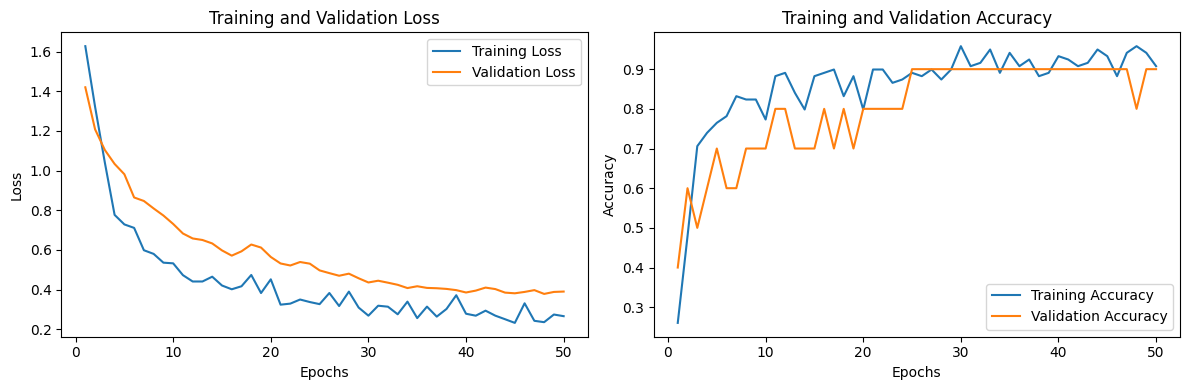

In [ ]:
import matplotlib.pyplot as plt
# Plotting training and validation information
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Load the best model weights
model.load_state_dict(best_model_weights)


<All keys matched successfully>

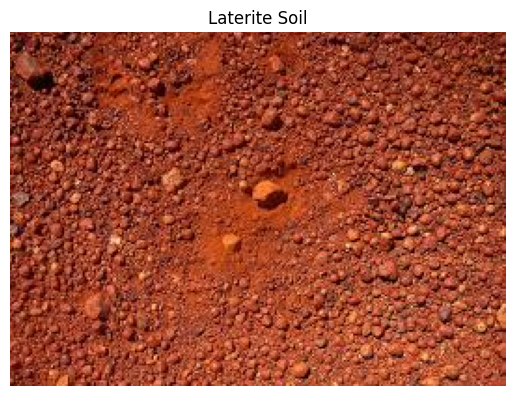

Predicted class: Laterite Soil


In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from PIL import Image

# Assuming you have loaded the best model weights into 'model'
model.eval()

# Move the model to the same device as the input data (CPU in this case)
device = torch.device("cpu")
model = model.to(device)

# Use the loaded model for predictions on new data
def predict_image(image_path):
    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    # Load and preprocess the input image
    image = Image.open(image_path)
    transformed_image = transform(image)
    transformed_image = transformed_image.unsqueeze(0) # Add batch dimension

    # Move the input data to the same device as the model
    transformed_image = transformed_image.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(transformed_image)

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    # Define the class names
    class_names = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil'] # Replace with your actual class names

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class.item()]

    # Display the original image
    plt.axis("off")
    plt.imshow(image)
    plt.title(predicted_class_name)
    plt.show()

    return predicted_class_name



# Example usage
image_path = '/content/drive/MyDrive/ss programs/Soil/test/Laterite Soil/2.jpg'
predicted_class = predict_image(image_path)
print(f'Predicted class: {predicted_class}')


In [ ]:
# Testing
model.eval()
test_correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / len(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7222


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

# Convert lists to tensors
true_labels = torch.tensor(true_labels)
predicted_labels = torch.tensor(predicted_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6985
Recall: 0.7222
F1 Score: 0.6839
